In [36]:
import torch
import torch.nn as nn
import torch.optim as optim

In [37]:
import numpy as np

In [38]:
import sys
sys.path.append('..')

from my_code import functions as f

# Data

In [39]:
file_path = '../data/energies/Trial/Strings_Energies.txt'  # Replace with the actual path to your 'data.txt' file
string_list, number_list = f.read_data_file(file_path)
score_list = np.array(number_list)/100
angles_list = np.array([f.string_to_numbers(string) for string in string_list])

In [40]:
X, Y, X_validation, Y_validation = f.create_validating_set(angles_list, score_list, percentage=0.1)

In [41]:
# Define the dataset
input_data = torch.tensor(X, dtype=torch.float32)
target_data = torch.tensor(Y, dtype=torch.float32).view(-1, 1)

# Define the validation set
input_validation = torch.tensor(X_validation, dtype=torch.float32)
target_validation = torch.tensor(Y_validation, dtype=torch.float32).view(-1, 1)

# Quantum node

In [42]:
def qml_RZZ(params, wires):
    """
    RZZ gate.
    """
    qml.CNOT(wires=wires)
    qml.RZ(params, wires=wires[1])
    qml.CNOT(wires=wires)

In [43]:
import pennylane as qml

n_qubits = 12
n_layers = 5
n_params = 3
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def qnode(inputs, weights):
    
    #state preparation
    qml.AngleEmbedding(inputs, wires=range(n_qubits))

    #layers
    for i in range(n_layers):
        # rotations for each qubit
        for j in range(n_qubits):
            qml.RX(weights[i,j,0], wires=j)
            qml.RZ(weights[i,j,1], wires=j)

        # ZZ rotation for neighboring qubits 
        for x in range(2):
            for j in range(x,n_qubits,2): 
                qml_RZZ(weights[i,j,2], wires=[j, (j+1)%n_qubits])

    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

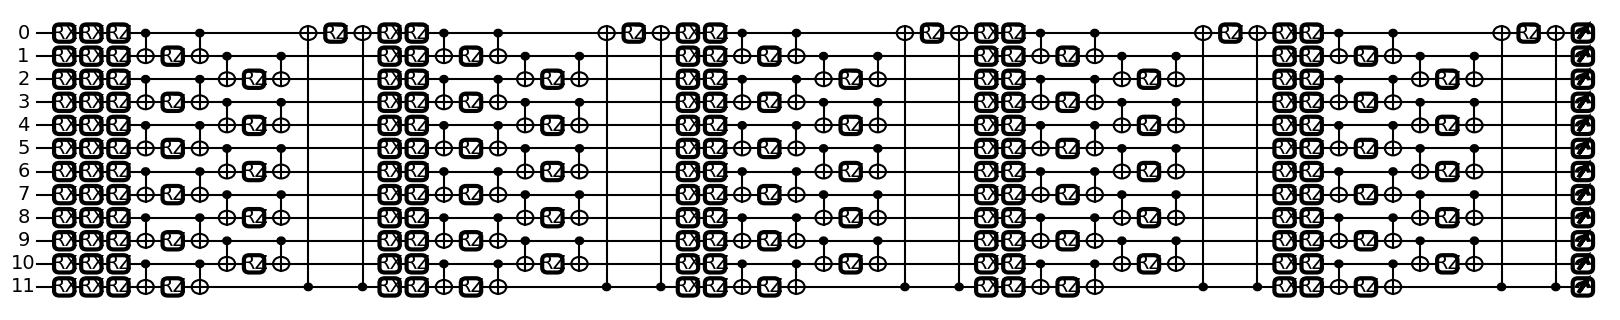

In [44]:
qml.drawer.use_style("black_white")
fig, ax = qml.draw_mpl(qnode, expansion_strategy="device")([i for i in range(12)], np.zeros((n_layers, n_qubits, n_params)))
fig.set_size_inches((16,3))

In [45]:
weight_shapes = {"weights": (n_layers, n_qubits, n_params)}

In [46]:
qlayer = qml.qnn.TorchLayer(qnode, weight_shapes)

# Classical model

In [47]:
input_dim = input_data.size(1)

layers =  [nn.Linear(input_dim*1, input_dim*2), nn.ReLU()]
layers += [nn.Linear(input_dim*2, input_dim*3), nn.ReLU()] 
layers += [nn.Linear(input_dim*3, input_dim*3), nn.ReLU()] 
layers += [nn.Linear(input_dim*3, input_dim*2), nn.ReLU()] 
layers += [nn.Linear(input_dim*2, input_dim*1)] 
layers += [qlayer] 
layers += [nn.Linear(input_dim*1, input_dim*1), nn.ReLU()] 
layers += [nn.Linear(input_dim*1, 1          ), nn.ReLU()] 
Net = nn.Sequential(*layers)

In [48]:
# # Define the neural network architecture
# class Net(nn.Module):
#     def __init__(self, input_dim):
#         super(Net, self).__init__()
#         self.fc1 = nn.Linear(input_dim, 64)
#         self.fc2 = nn.Linear(64, 64)
#         self.fc3 = nn.Linear(64, 64)
#         self.fc4 = nn.Linear(64, 64)
#         self.fc5 = nn.Linear(64, 64)
#         self.fc6 = nn.Linear(64, 32)
#         self.fc7 = nn.Linear(32, 1)

#     def forward(self, x):
#         x = torch.relu(self.fc1(x))
#         x = torch.relu(self.fc2(x))
#         x = torch.relu(self.fc3(x))
#         x = torch.relu(self.fc4(x))
#         x = torch.relu(self.fc5(x))
#         x = torch.relu(self.fc6(x))
#         x = self.fc7(x)
#         return x

In [49]:
# Create an instance of the network
model = Net

In [50]:
# from torchsummary import summary
# #draw the model
# summary(model, (input_dim,))

In [51]:
# Define the loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error loss
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer with learning rate 0.001

# Training loop
num_epochs = 100
batch_size = 32

losses = []
losses_epochs = []

for epoch in range(num_epochs):
    # Shuffle the dataset
    indices = torch.randperm(input_data.size(0))
    input_data = input_data[indices]
    target_data = target_data[indices]

    # Mini-batch training
    for i in range(0, input_data.size(0), batch_size):
        inputs = input_data[i:i+batch_size]
        targets = target_data[i:i+batch_size]

        # Forward pass
        outputs = model(inputs)

        # Compute the loss
        loss = criterion(outputs, targets)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Store the loss
        losses.append(loss.item())

        print('- Epoch [{}/{}], i: [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, i, input_data.size(0), loss.item()))

    losses_epochs.append(criterion(input_data, target_data).item())

    # Print the loss for this epoch
    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))


- Epoch [1/100], i: [0/900], Loss: 28.1934
- Epoch [1/100], i: [32/900], Loss: 16.4846
- Epoch [1/100], i: [64/900], Loss: 31.1553
- Epoch [1/100], i: [96/900], Loss: 23.0759
- Epoch [1/100], i: [128/900], Loss: 25.1122
- Epoch [1/100], i: [160/900], Loss: 23.1198
- Epoch [1/100], i: [192/900], Loss: 19.2669
- Epoch [1/100], i: [224/900], Loss: 15.8442
- Epoch [1/100], i: [256/900], Loss: 20.6173
- Epoch [1/100], i: [288/900], Loss: 27.0040
- Epoch [1/100], i: [320/900], Loss: 26.5823
- Epoch [1/100], i: [352/900], Loss: 24.8630
- Epoch [1/100], i: [384/900], Loss: 18.0369
- Epoch [1/100], i: [416/900], Loss: 16.0330
- Epoch [1/100], i: [448/900], Loss: 24.7199


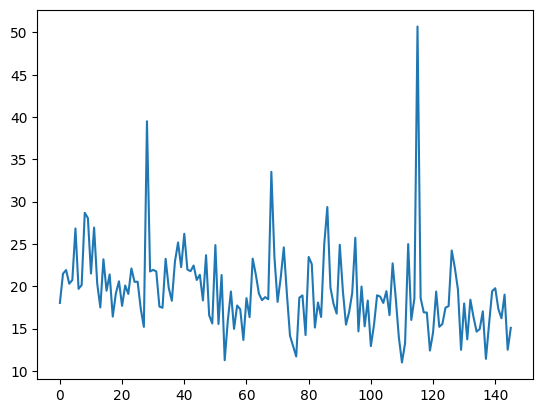

In [ ]:
#plot the loss
import matplotlib.pyplot as plt
plt.plot(losses)
plt.show()

In [ ]:
#plot the loss
import matplotlib.pyplot as plt
plt.plot(losses_epochs)
plt.show()

In [ ]:
for x, (i, t) in enumerate(zip((input_validation), target_validation)):
    loss = criterion(model(i), t)
    avg_loss += loss/len(target_validation)
    print('i: {}, target: {:.3f}, output: {:.3f}, loss: {:.3f}'.format(x, t.item(), model(i).item(), loss))
    print('')

print('Average loss: {:.3f}'.format(avg_loss))

i: 0, target: 9.893, output: 2.471, loss: 55.076

i: 1, target: 5.435, output: 2.988, loss: 5.991

i: 2, target: 0.783, output: 4.531, loss: 14.045

i: 3, target: 1.235, output: 0.846, loss: 0.152

i: 4, target: 1.874, output: 5.050, loss: 10.085

i: 5, target: 7.860, output: -0.775, loss: 74.557

i: 6, target: 5.790, output: 7.812, loss: 4.091

i: 7, target: 4.322, output: 4.708, loss: 0.149

i: 8, target: 4.329, output: 9.844, loss: 30.406

i: 9, target: 7.716, output: 4.387, loss: 11.081

i: 10, target: 3.405, output: 2.255, loss: 1.323

i: 11, target: -0.502, output: 4.134, loss: 21.494

i: 12, target: 1.077, output: -0.403, loss: 2.189

i: 13, target: 3.705, output: 5.007, loss: 1.697

i: 14, target: 1.932, output: 6.028, loss: 16.776

i: 15, target: 2.903, output: 7.514, loss: 21.260

i: 16, target: 5.507, output: 5.298, loss: 0.044

i: 17, target: 3.952, output: 1.712, loss: 5.018

i: 18, target: 3.888, output: 2.072, loss: 3.297

i: 19, target: 6.623, output: 9.711, loss: 9.536